<img src="imgs/dh_logo.png" align="right" width="50%">

________________

## Apêndice 1

#### Clustering para processamento de imagens (compactação de cores)


#### Finalmente, vamos usar um `plotting` com [`data compression`]() para visualizar os resultados:

```python
from sklearn.manifold import TSNE
import matplotlib.colors

tsne = TSNE()
results_tsne = tsne.fit_transform(X)

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(cluster_values, 
                                                           color_list
                                                          )

plt.scatter(results_tsne[:,0], results_tsne[:,1],
    c =  df_uci_pivot.index.get_level_values('cluster'),
    cmap = cmap, 
    alpha = 0.6, 
    )
```

#### Plotamos uma imagem original.

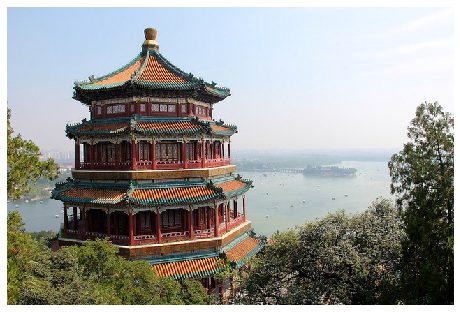

In [120]:
from sklearn.datasets import load_sample_image

china = load_sample_image("china.jpg")

ax = plt.axes(xticks = [], 
              yticks = []
             )
ax.imshow(china);

#### Verificamos o tamanho dos dados.

In [121]:
china.shape

(427, 640, 3)

#### Normalizamos a escala dos dados

In [122]:
data = china / 255.0 

# alterando o tamnho dos dados
data = data.reshape(427 * 640, 3)

data.shape

(273280, 3)

#### Plotamos o gráfico com todas as possibilidades de cores, por volta de $16$ milhões.

In [123]:
def plot_pixels(data, title, colors = None, N = 10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize = (16, 6))

    ax[0].scatter(R, 
                  G, 
                  color = colors, 
                  marker = '.'
                 )

    ax[0].set(xlabel = 'Red', 
              ylabel = 'Green', 
              xlim = (0, 1), 
              ylim = (0, 1)
             )

    ax[1].scatter(R, 
                  B, 
                  color = colors, 
                  marker = '.'
                 )

    ax[1].set(xlabel = 'Red', 
              ylabel = 'Blue', 
              xlim = (0, 1), 
              ylim = (0, 1)
             )

    fig.suptitle(title, size = 20);

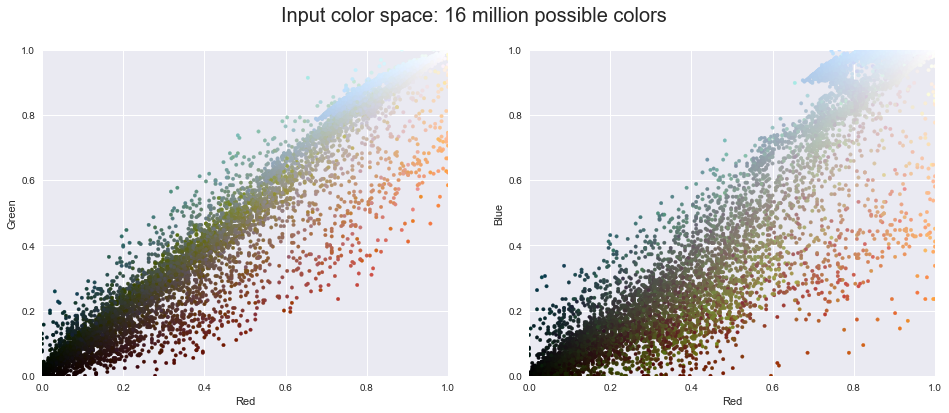

In [124]:
plot_pixels(data, title = 'Input color space: 16 million possible colors')

#### Podemos reduzir onúmero de cores para $16$.

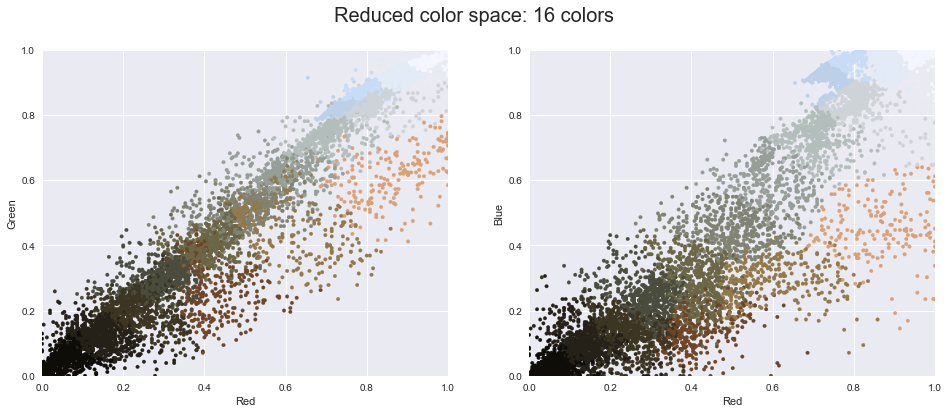

In [126]:
import warnings; warnings.simplefilter('ignore')  # Fix NumPy issues.

# Vamos reduzir os 16Mi para 16 cores utilizando kMeans
from sklearn.cluster import MiniBatchKMeans

kmeans = MiniBatchKMeans(16)
kmeans.fit(data)

new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, 
            colors = new_colors, 
            title = "Reduced color space: 16 colors"
           )

#### Comparando a imagem original com aquela com apenas $16$ cores.

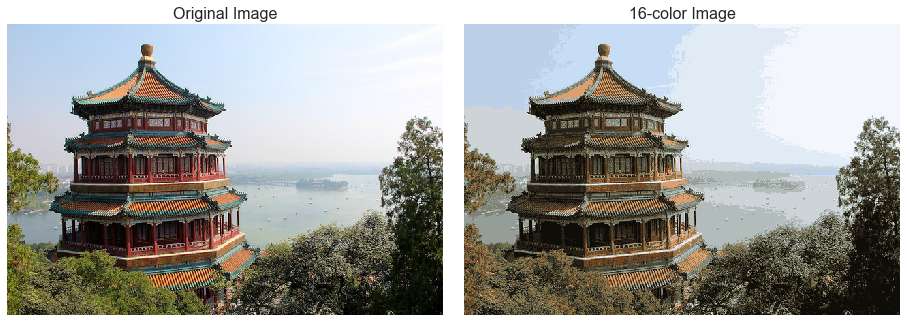

In [127]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 
                       2, 
                       figsize = (16, 6),
                       subplot_kw = dict(xticks = [], yticks = [])
                      )
fig.subplots_adjust(wspace = 0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size = 16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size = 16);

------------

## Apêndice 2

#### [Comparando algoritmos](http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html) de `clustering` diferentes em conjuntos de dados.

#### Este exemplo mostra características de diferentes algoritmos de agrupamento em conjuntos de dados que são interessantes, mas ainda em $2D$. Com exceção do último conjunto de dados, os parâmetros de cada um desses pares de algoritmos de conjunto de dados foram ajustados para produzir bons resultados de `cluster`. Alguns algoritmos são mais sensíveis aos valores dos parâmetros do que outros.

#### O último conjunto de dados é um exemplo de uma situação "nula" para `cluster`: os dados são homogêneos e não há um bom agrupamento. Neste exemplo, o conjunto de dados nulo usa os mesmos parâmetros que o conjunto de dados na linha acima, o que representa uma incompatibilidade nos valores dos parâmetros e na estrutura de dados.

#### Embora esses exemplos ofereçam alguma intuição sobre os algoritmos, essa intuição pode não se aplicar a dados dimensionais muito altos.

Automatically created module for IPython interactive environment


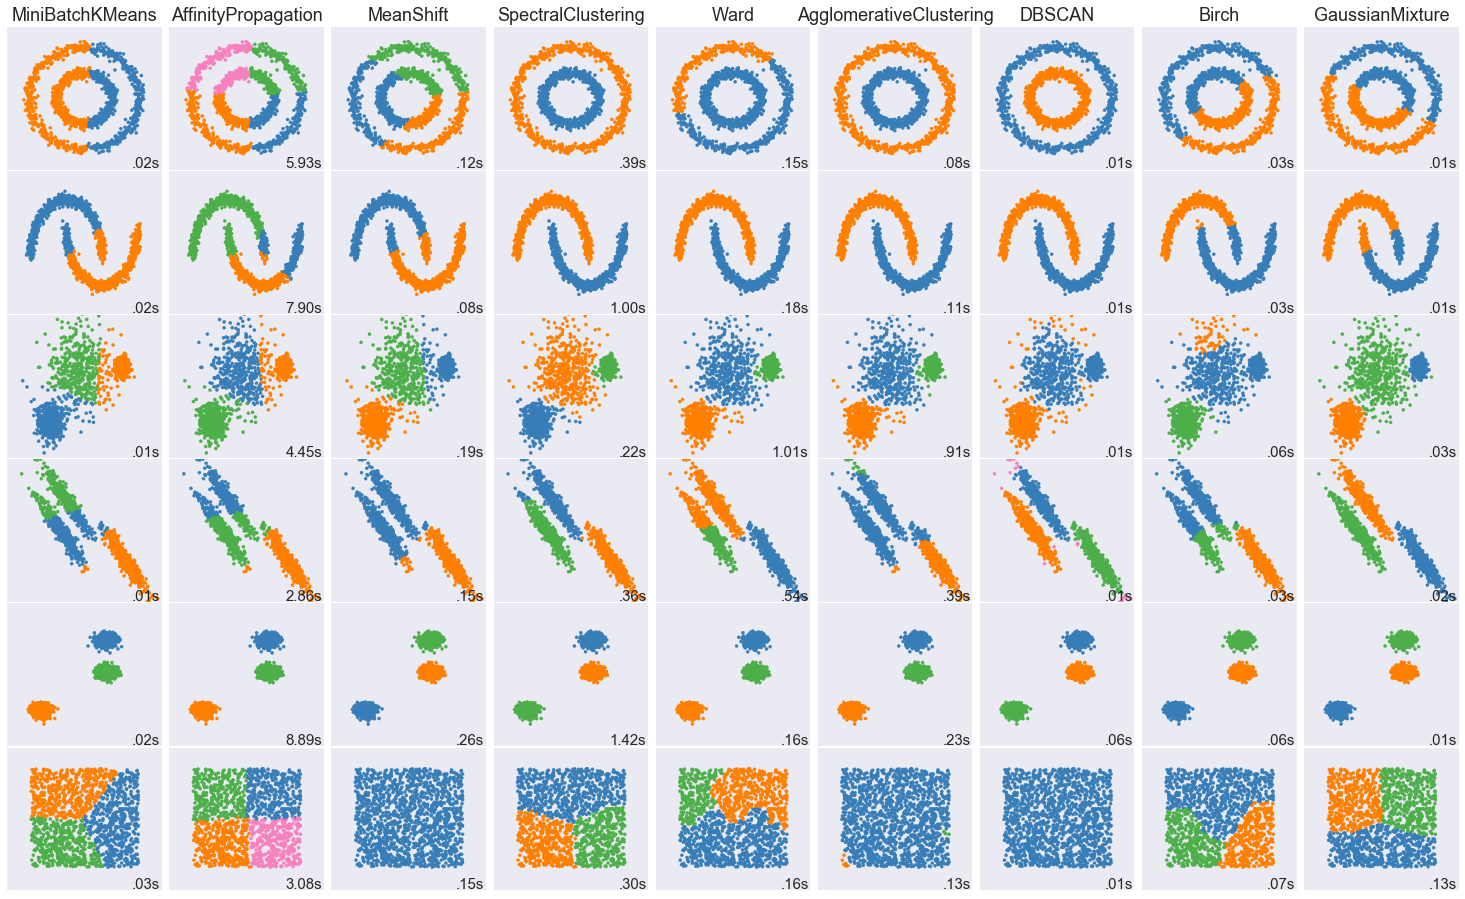

In [128]:
print(__doc__)

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============

n_samples = 1500
noisy_circles = datasets.make_circles(n_samples = n_samples, 
                                      factor = 0.5, 
                                      noise = 0.05
                                     )
noisy_moons = datasets.make_moons(n_samples = n_samples, 
                                  noise = 0.05
                                 )
blobs = datasets.make_blobs(n_samples = n_samples, 
                            random_state = 8
                           )
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples = n_samples, 
                           random_state = random_state
                          )
transformation = [[0.6, -0.6], 
                  [-0.4, 0.8]
                 ]

X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples = n_samples,
                             cluster_std = [1.0, 2.5, 0.5],
                             random_state = random_state
                            )
# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left = 0.02, 
                    right = 0.98, 
                    bottom = 0.001, 
                    top = 0.96, 
                    wspace = 0.05,
                    hspace = 0.01
                   )

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3
               }

datasets = [ (noisy_circles, {'damping': .77, 'preference': -240, 'quantile': .2, 'n_clusters': 2}), 
            (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
            (varied, {'eps': .18, 'n_neighbors': 2}), 
            (aniso, {'eps': .15, 'n_neighbors': 2}), 
            (blobs, {}), 
            (no_structure, {}) 
           ]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, 
                                           quantile = params['quantile']
                                          )

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(X, 
                                    n_neighbors = params['n_neighbors'], 
                                    include_self = False
                                   )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth = bandwidth, 
                           bin_seeding = True
                          )
    two_means = cluster.MiniBatchKMeans(n_clusters = params['n_clusters'])

    ward = cluster.AgglomerativeClustering(
        n_clusters = params['n_clusters'], 
        linkage = 'ward',
        connectivity=connectivity
    )

    spectral = cluster.SpectralClustering(
        n_clusters = params['n_clusters'], 
        eigen_solver = 'arpack',
        affinity = "nearest_neighbors"
    )
    
    dbscan = cluster.DBSCAN(eps = params['eps'])
    
    affinity_propagation = cluster.AffinityPropagation(
        damping = params['damping'], 
        preference = params['preference']
    )
    
    average_linkage = cluster.AgglomerativeClustering(
        linkage = "average", 
        affinity = "cityblock", 
        n_clusters = params['n_clusters'], 
        connectivity = connectivity
    )
    
    birch = cluster.Birch(n_clusters = params['n_clusters'])

    gmm = mixture.GaussianMixture(
        n_components = params['n_clusters'], 
        covariance_type = 'full'
    )

    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        ('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('Birch', birch),
        ('GaussianMixture', gmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message = "the number of connected components of the " + "connectivity matrix is [0-9]{1,2}" + " > 1. Completing it to avoid stopping the tree early.",
                category = UserWarning
            )
            
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" + " may not work as expected.",
                category = UserWarning
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), 
                    len(clustering_algorithms), 
                    plot_num
                   )
        if i_dataset == 0:
            plt.title(name, size = 18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']
                                           ), 
                                      int(max(y_pred) + 1)
                                     )
                              )
                         )
        
        plt.scatter(X[:, 0], 
                    X[:, 1], 
                    s = 10, 
                    color = colors[y_pred]
                   )

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show();